In [1]:
# Things to fix
# 
# 
# Move stuff to utils 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
import os

from collections import Counter
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import make_pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import ClassifierMixin
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest # outliers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import sklearn
sklearn.set_config(print_changed_only=True, display='diagram')

from joblib import dump, load


np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "wine_qual_clf_model_reds"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, 'models', PROJECT_ID)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """ 
    resolution quality
    300 high 
    150 medium
    72 low
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def save_metric(model):
    """ 
    resolution quality
    300 high 
    150 medium
    72 low
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Classes and Functions

def g_mean_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return np.sqrt(recall*precision)


scoring = {
    'precision':make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy' : make_scorer(accuracy_score),
    'roc_auc' : make_scorer(roc_auc_score),
    'geo_mean' : make_scorer(g_mean_score)
          }

def get_sorted_params(pipeline):
    pp.pprint(sorted(pipeline.get_params().keys()))

class CustomImputer(TransformerMixin, BaseEstimator):
    def __init__(self, impute_type=None):
        # Set initial values for the attributes of the class.
        # We will expect impute_type to be one of "mean" or "median"
        self.impute_vals = None
        self.impute_type = impute_type
        
    def fit(self, X, y=None):
    # Compute the values for imputation using the method select at time of class init.
        if self.impute_type == "median":
            self.impute_vals = X.median()
        else:
            self.impute_vals = X.mean()

        return self

    def transform(self, X):
        # Fill missing values using the summary statistics computed when fit was run.
        return X.fillna(self.impute_vals)
    
class CustomImputeOutputTransformer(CustomImputer):
    def __init__(self, impute_type=None):
        CustomImputeTransformer.__init__(self, impute_type)
        
    def fit(self, X, y=None):
        # Compute the result of fit from the parent class.
        result = super(CustomImputeOutputTransformer, self).fit(X, y)
        
        # Print the imputation type and the imputation values computation during this call of fit.
        print("Impute type", self.impute_type)
        print("Impute vals", self.impute_vals)
        
        return result

class OutlierExtractor(TransformerMixin):
    def __init__(self, ** kwargs):
        self.threshold = kwargs.pop('neg_conf_val', -10.0)
        self.kwargs = kwargs

    def transform(self, X, y):
        y = np.asarray(y)
        lcf = LocalOutlierFactor( ** self.kwargs)
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold,: ],
        y[lcf.negative_outlier_factor_ > self.threshold])

    def fit(self, * args, ** kwargs):
        return self
    
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");
    
def plot_classification_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)
    
def plot_decision_boundary_pca(dfs, best_model):
    df = dfs.dropna()

    # Remove Outliers
    mask = IsolationForest().fit_predict(df[features])
    df['mask'] = mask
    df = df[df['mask'] == 1]
    df = df.reset_index(drop=True)

    X, y = df[features], df['quality'].apply(lambda x:0 if x<=6 else 1)

    # Apply Transformations
    X = PowerTransformer().fit_transform(X)

    # Reduce Dimensions
    decomp = PCA(n_components=2)
    reduced = decomp.fit_transform(X, y)
    reduced = pd.DataFrame(reduced, columns=['pc_1', 'pc_2'])
    reduced = pd.concat([reduced, y], axis=1)
    model = best_model
    model.fit(reduced.drop('quality', axis=1), reduced['quality'])

    h=0.02

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced.iloc[:, 0].min(), reduced.iloc[:, 0].max()
    y_min, y_max = reduced.iloc[:, 1].min(), reduced.iloc[:, 1].max()
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(10,10))
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.25, colors=['red', 'black', 'green', 'red'])
    highs = reduced[reduced['quality']==1]
    lows = reduced[reduced['quality']==0]
    plt.scatter(highs['pc_1'], highs['pc_2'], color='green', marker='o', alpha=0.7, edgecolor='k', linewidth=1.0, label='high quality')
    plt.scatter(lows['pc_1'], lows['pc_2'], color='red', marker='.',alpha=0.4, label='low quality')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.legend(loc='best')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if 'steps' in model.get_params().keys():
        plt.title('{} Decision Boundary'.format(model.get_params()['steps'][1][0]).capitalize())
        save_fig('{} Decision Boundary'.format(model.get_params()['steps'][1][0]).capitalize(), resolution=72)
    else:
        plt.title('Stacking Classifier {}'.format(model.final_estimator_.steps[1][0]))
        save_fig('stacking_classifier_{}'.format(model.final_estimator_.steps[1][0]), resolution=72)
    plt.show()
    
def plot_dark_decision_boundary(dfs, best_model):
    df = dfs.copy(deep=True)
    df[features] = PowerTransformer().fit_transform(reds[features])

    X, y = df[features], df['quality'].apply(lambda x:0 if x<=6 else 1)

    # Reduce Dimensions
    reduced = df[['volatile acidity', 'alcohol']]
    reduced = pd.concat([reduced, y], axis=1)
    model = best_model
    model.fit(reduced.drop('quality', axis=1), reduced['quality'])

    h=0.02

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced.iloc[:, 0].min(), reduced.iloc[:, 0].max()
    y_min, y_max = reduced.iloc[:, 1].min(), reduced.iloc[:, 1].max()
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    f, (ax1) = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
    f.patch.set_facecolor('red')
    f.patch.set_alpha(0.0)
    reds_tsfm = reds.copy(deep=True)
    reds_tsfm[features] = PowerTransformer().fit_transform(reds[features])

    f.suptitle('Decision Boundaries red Wines', fontsize=16, c='red')

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)


    # Plotting
    ax1.contour(xx, yy, Z, alpha=0.35,)
    ax1.contourf(xx, yy, Z, alpha=0.05, levels=1, colors=['black', 'green', 'green'])
    sns.scatterplot(x='volatile acidity',
                    y='alcohol',
                    data=reds_tsfm,
                    palette=['palegoldenrod', 'lightyellow'],
                    hue='class',
                    size='class',
                    edgecolor='k',
                    sizes=[50, 200],
                    ax=ax1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(model)

    ax1.spines['top'].set_color(None)
    ax1.spines['bottom'].set_color(None)
    ax1.spines['left'].set_color(None)
    ax1.spines['right'].set_color(None)
    ax1.xaxis.label.set_color('red')
    ax1.get_legend().remove()
    ax1.tick_params(axis='x', colors='red')
    ax1.axes.xaxis.set_visible(True)
    ax1.axes.yaxis.set_visible(True)
    ax1.tick_params(axis='y', colors='red')
    ax1.set_xlabel("Volatile Acidity",size = 14, c='red')
    ax1.set_ylabel("Alcohol %",size = 16, c='red')
    ax1.patch.set_facecolor('red')
    ax1.patch.set_alpha(0.0)
    ax1.grid(False)
    if 'steps' in model.get_params().keys():
        ax1.set_title('{}'.format(model.get_params()['steps'][1][0]).capitalize(), c='red')
        save_fig('dark_{}_countour'.format(model.get_params()['steps'][1][0]), resolution=72)
    else:
        ax1.set_title('Stacking Classifier {}'.format(model.final_estimator_.steps[1][0]), c='red')
        save_fig('stacking_classifier_{}_dark'.format(model.final_estimator_.steps[1][0]), resolution=72)

    # If we don't specify the edgecolor and facecolor for the figure when
    # saving with savefig, it will override the value we set earlier
    plt.show()
# countour plots https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

#def save_to_metrics_file(model)

In [4]:
features = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide',
       'pH', 'sulphates', 'alcohol']

# Read in the Data, Do Preprocessing on Training Set, and set up Train Val Split

In [5]:
reds = pd.read_pickle('./data/red_train.pkl')
reds = reds.drop_duplicates()

#ros = RandomOverSampler

# red Wine Training/Testing

# Do feature elimination tests during hyperparameter testing

X, y = reds[features], reds['quality'].apply(lambda x:0 if x <= 6 else 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)

In [6]:
#features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',  'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',  'pH', 'sulphates', 'alcohol']

In [7]:
y_val.value_counts()

0    224
1     35
Name: quality, dtype: int64

# Build Pipelines

In [8]:

# Estimator Pipelines
lgr_pipeline = make_pipeline(PowerTransformer(), LogisticRegression(n_jobs = -1, random_state=0, class_weight='balanced'))

rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'))

svm_pipeline = make_pipeline(PowerTransformer(), SVC(kernel='rbf', random_state=0, probability=True, class_weight='balanced'))

knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_jobs=-1))

# Testing Parameters

In [9]:
# Uncomment to get list of knn_pipeline parameters
# get_sorted_params(knn_pipeline)

In [10]:
%%time

# KNN classifier hyperparameter tuning
param_grid = {
    # KNN Hyperparameters
 'kneighborsclassifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
 'kneighborsclassifier__leaf_size':np.linspace(10,60, 6).astype(int),
 'kneighborsclassifier__n_neighbors':np.linspace(1,100, 100).astype(int),
 'kneighborsclassifier__p':[1,2],
 'kneighborsclassifier__weights':['uniform', 'distance']
}

knn_cv = RandomizedSearchCV(knn_pipeline, 
                              param_distributions=param_grid, 
                              cv=10, scoring=scoring, 
                              refit='roc_auc', 
                              return_train_score=True,
                              error_score='raise',
                                    random_state=0,
                                n_iter=40,
                               verbose=0
                             )

knn_cv.fit(X_train, y_train)

CPU times: user 26.5 s, sys: 2.28 s, total: 28.7 s
Wall time: 48.3 s


RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=40,
                   param_distributions={'kneighborsclassifier__algorithm': ['auto',
                                                                            'ball_tree',
                                                                            'kd_tree',
                                                                            'brute'],
                                        'kneighborsclassifier__leaf_size': array([10, 20, 30, 40, 50, 60]),
                                        'kneighborsclassifi...
        92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'kneighborsclassifier__p': [1, 2],
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance']},
                   random_state=0, refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

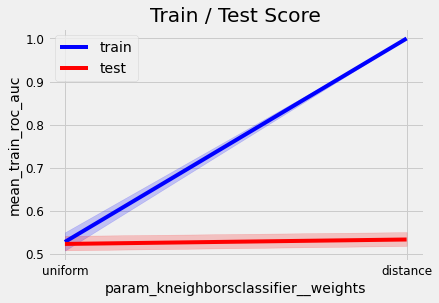

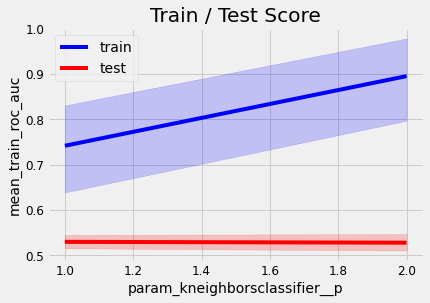

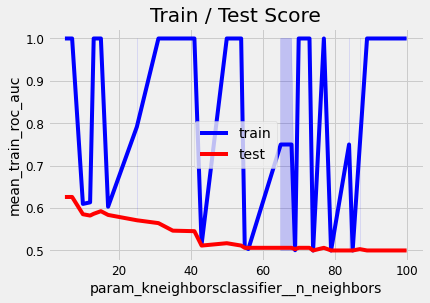

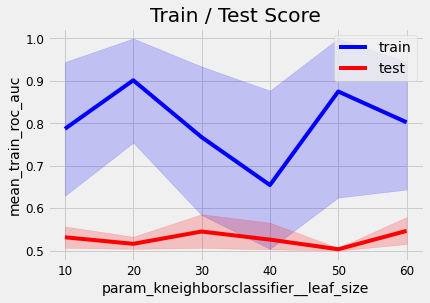

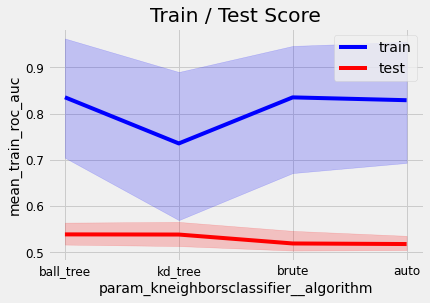

In [11]:
knn_tuning  = pd.DataFrame(knn_cv.cv_results_)
params = list(knn_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=knn_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=knn_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'], loc='best')
    plt.title('Train / Test Score')

    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       224
           1       0.67      0.34      0.45        35

    accuracy                           0.89       259
   macro avg       0.79      0.66      0.70       259
weighted avg       0.87      0.89      0.87       259



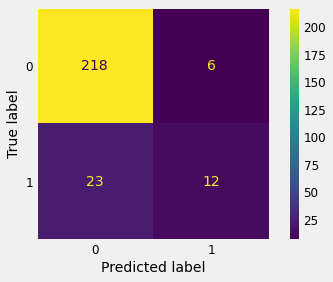

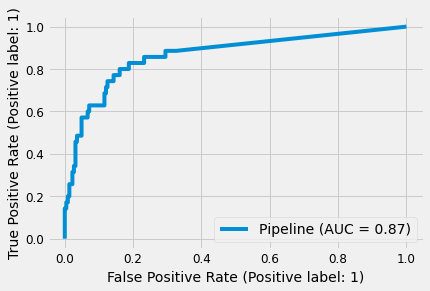

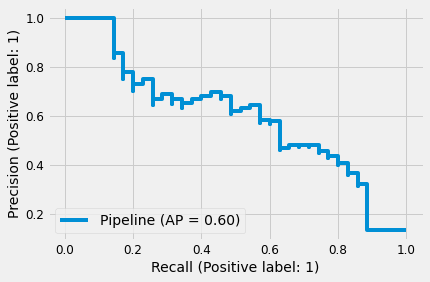

In [12]:
clf = knn_cv.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plot_roc_curve(clf, X_val, y_val)
plot_precision_recall_curve(clf, X_val, y_val)


In [13]:
best_knn_model = knn_cv.best_estimator_
# Save model
dump(best_knn_model, './red_wines_knn.joblib') 

['./red_wines_knn.joblib']

Saving figure Kneighborsclassifier decision boundary


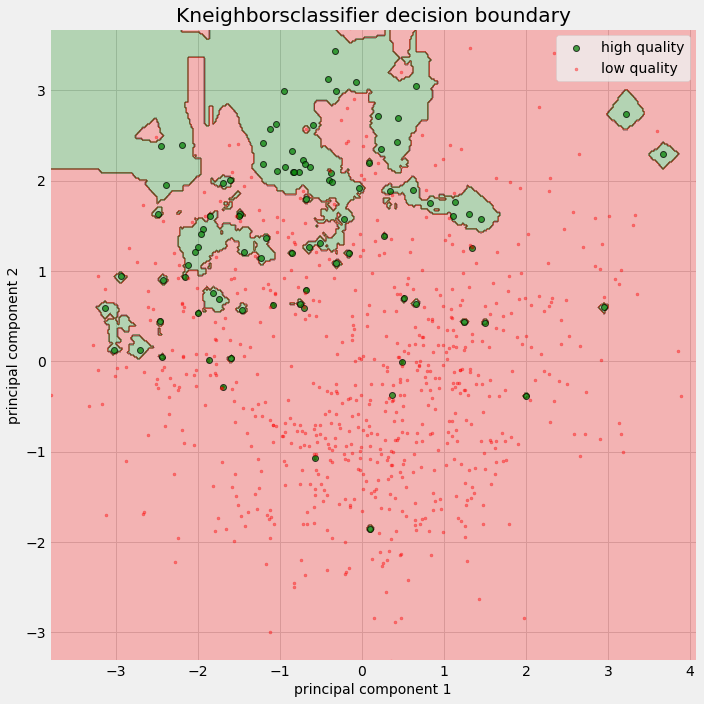

In [14]:
plot_decision_boundary_pca(reds, best_knn_model)

In [15]:
#plot_dark_decision_boundary(reds, best_knn_model)

# Random Forest

In [16]:
#RF Hyperparameters

rf_n_estimators = np.linspace(1, 100, 100).astype(int)
rf_max_depths = np.linspace(1, 100, 100, endpoint=True)
rf_min_samples_splits = np.linspace(0.01, 1.0, 100, endpoint=True)
rf_min_samples_leafs = np.linspace(0.01, 0.5, 100, endpoint=True)
rf_max_features = ["auto", "sqrt", "log2"]
rf_criterion = ['gini', 'entropy']

In [17]:
%%time
param_grid = {
    'randomforestclassifier__max_features':rf_max_features,
    'randomforestclassifier__n_estimators':rf_n_estimators,
    'randomforestclassifier__max_depth': rf_max_depths,
    'randomforestclassifier__criterion': rf_criterion,
    'randomforestclassifier__min_samples_split':rf_min_samples_splits,
    'randomforestclassifier__min_samples_leaf':rf_min_samples_leafs,
    
}

rf_cv = RandomizedSearchCV(rf_pipeline, 
                              param_distributions=param_grid, 
                              cv=10, scoring=scoring, 
                              refit='roc_auc', 
                              return_train_score=True,
                              error_score='raise',
                                    random_state=0,
                                n_iter=40,
                               verbose=0
                             )

rf_cv.fit(X_train, y_train)

CPU times: user 55 s, sys: 6.23 s, total: 1min 1s
Wall time: 1min 21s


RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=0))]),
                   n_iter=40,
                   param_distributions={'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'randomforestclassifier__max_depth': array([  1.,   2.,   3.,   4.,...
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
                   random_state=0, refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

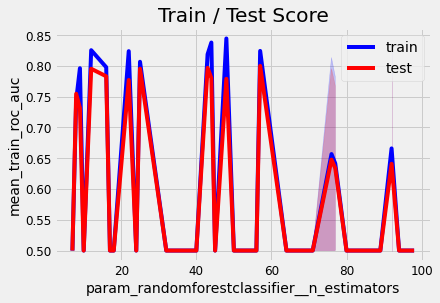

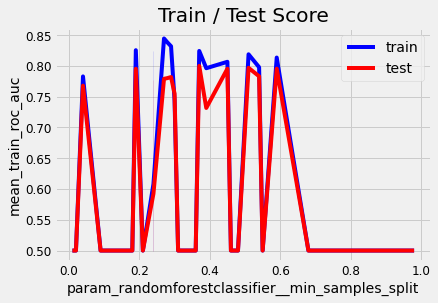

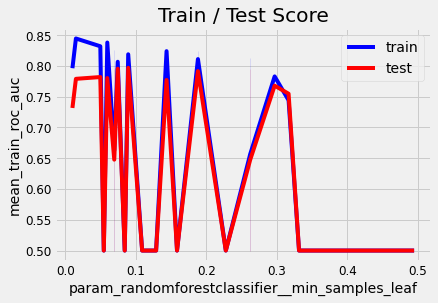

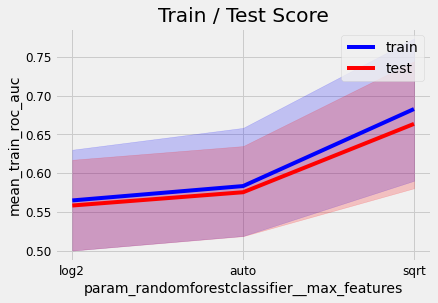

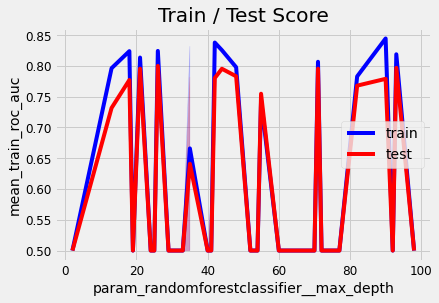

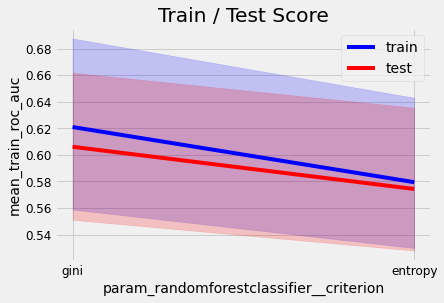

In [18]:
rf_tuning  = pd.DataFrame(rf_cv.cv_results_)
params = list(rf_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=rf_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=rf_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'])
    plt.title('Train / Test Score')

    plt.show()

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       224
           1       0.33      0.80      0.47        35

    accuracy                           0.76       259
   macro avg       0.65      0.78      0.66       259
weighted avg       0.88      0.76      0.79       259



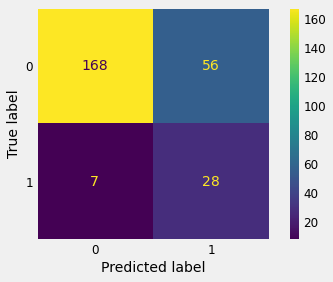

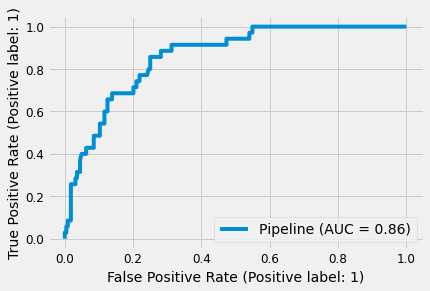

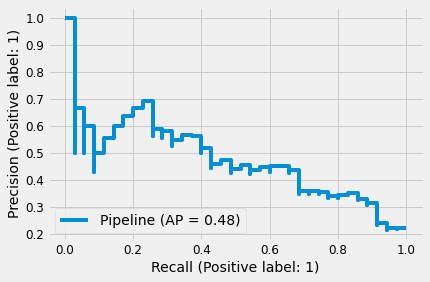

In [19]:
clf = rf_cv.best_estimator_
# Save model
dump(clf, './red_wines_rf.joblib') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plt.show()
plot_roc_curve(clf, X_val, y_val)
plt.show()
plot_precision_recall_curve(clf, X_val, y_val)
plt.show()

In [20]:
best_rf_model = rf_cv.best_estimator_
# Save model
dump(best_rf_model, './red_wines_rf.joblib') 

['./red_wines_rf.joblib']

Saving figure Randomforestclassifier decision boundary


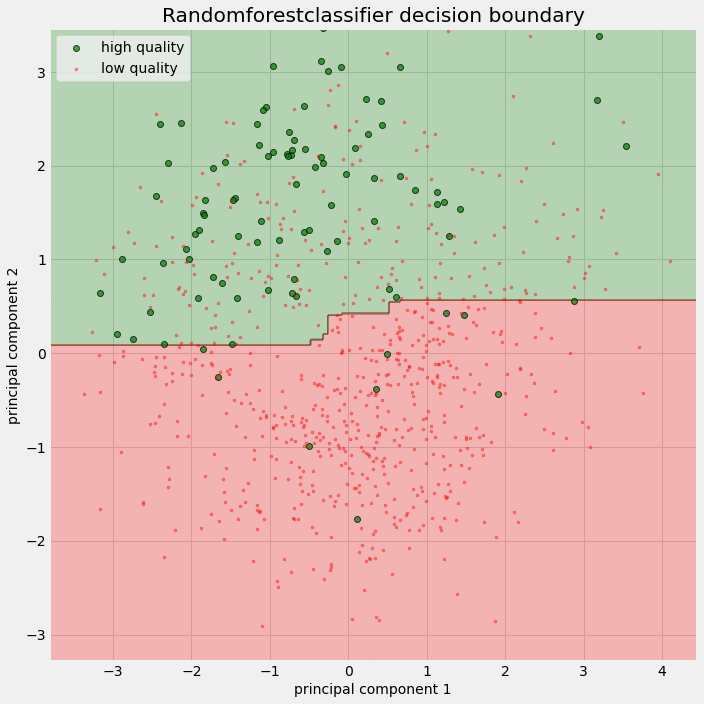

In [21]:
plot_decision_boundary_pca(reds, best_rf_model)

In [22]:
#plot_dark_decision_boundary(reds, best_rf_model)

# Logistic Regression

In [23]:
#LGR Hyperparameters

lgr_regularization = np.logspace(-6,2,9)
lgr_penalties = ['l1', 'l2', 'elasticnet', 'none']
lgr_solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lgr_scalers = [StandardScaler(), QuantileTransformer(), PowerTransformer(), MinMaxScaler()]
lgr_max_iters = np.linspace(500, 2000, 100).astype(int)


In [24]:
%%time
param_grid = {
    
    #preprocessing
    
 'logisticregression__C': lgr_regularization,
    'logisticregression__penalty':lgr_penalties,
    'logisticregression__solver':lgr_solvers,
    'logisticregression__max_iter': lgr_max_iters,
}

lgr_cv = RandomizedSearchCV(lgr_pipeline, 
                              param_distributions=param_grid, 
                              cv=10, scoring=scoring, 
                              refit='roc_auc', 
                              return_train_score=True,
                                    random_state=0,
                                n_iter=40,
                            verbose=0
                             )

lgr_cv.fit(X_train, y_train)

CPU times: user 22.2 s, sys: 518 ms, total: 22.7 s
Wall time: 43.5 s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('powertransformer',
                                              PowerTransformer()),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 n_jobs=-1,
                                                                 random_state=0))]),
                   n_iter=40,
                   param_distributions={'logisticregression__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02]),
                                        'logisticregression__max_iter': array([...
                                                                        'elasticnet',
                                                                        'none'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear',
                                                                       'sag',
                                                                       'saga']},
                   random_state=0, refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

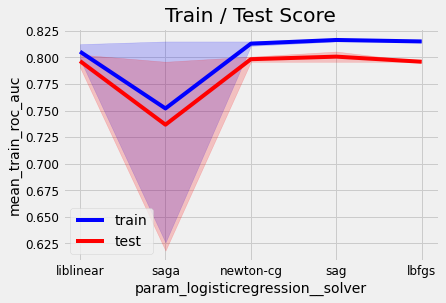

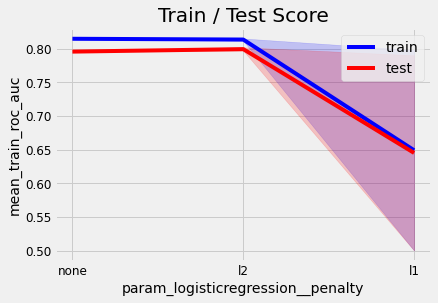

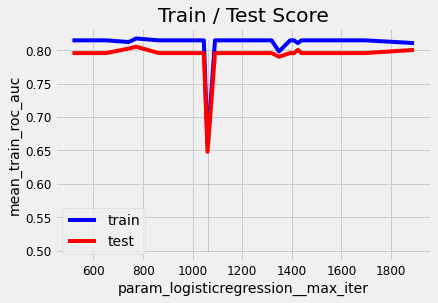

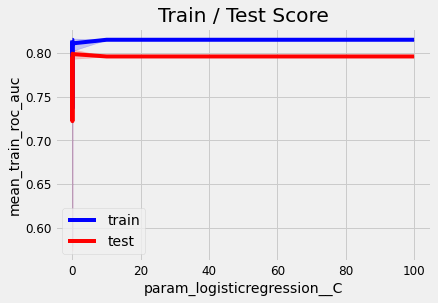

In [25]:
lgr_tuning  = pd.DataFrame(lgr_cv.cv_results_)
params = list(lgr_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=lgr_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=lgr_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'])
    plt.title('Train / Test Score')
    plt.show()

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       224
           1       0.38      0.86      0.53        35

    accuracy                           0.80       259
   macro avg       0.68      0.82      0.70       259
weighted avg       0.89      0.80      0.82       259



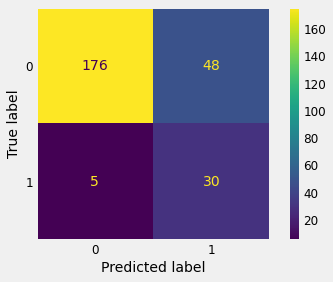

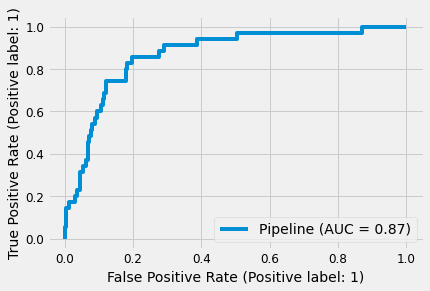

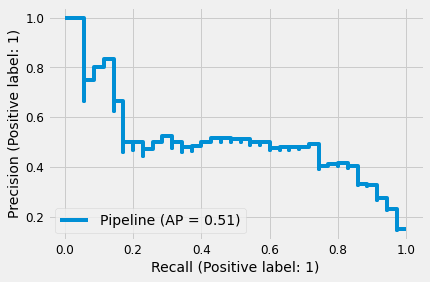

In [26]:
clf = lgr_cv.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plot_roc_curve(clf, X_val, y_val)
plot_precision_recall_curve(clf, X_val, y_val)

In [27]:
best_lgr_model = lgr_cv.best_estimator_
dump(best_lgr_model, './red_wines_lgr.joblib') 

['./red_wines_lgr.joblib']

Saving figure Logisticregression decision boundary


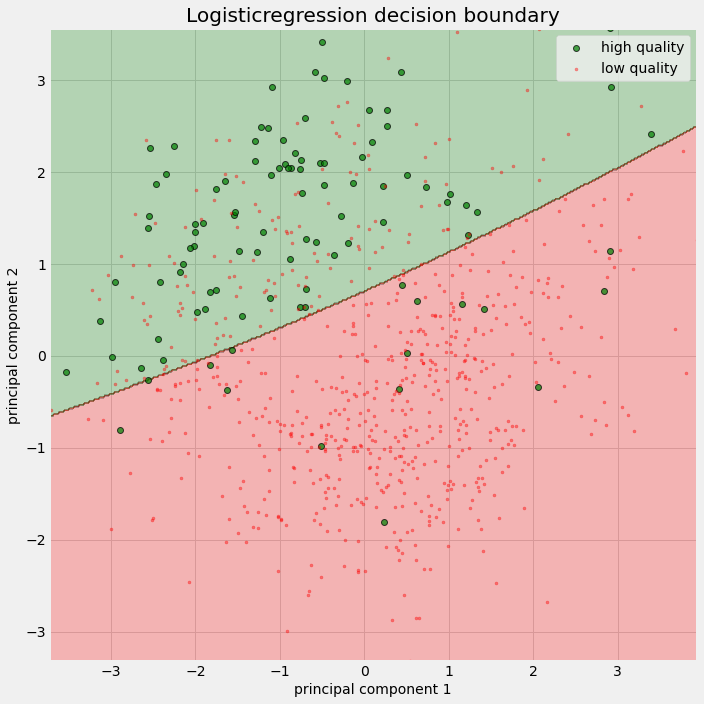

In [28]:
plot_decision_boundary_pca(reds, best_lgr_model)

In [29]:
#plot_dark_decision_boundary(reds, best_lgr_model)

# Support Vector Machines

In [30]:
#SVM Hyperparameters

svm_penalties = np.logspace(-1,5,7)
svm_gammas = np.logspace(-6,-3,3)
svm_scalers = [MinMaxScaler()]
smv_kernels = ['rbf', 'poly', 'sigmoid', 'linear']

In [31]:
# get_sorted_params(svm_pipeline)

In [32]:
%%time
param_grid = { 
 'svc__C':svm_penalties,
 'svc__gamma': svm_gammas,
 'svc__kernel': ['sigmoid', 'rbf', 'poly'],
 'svc__degree':[2,3,4,5,6]
}

svm_cv = RandomizedSearchCV(svm_pipeline, 
                              param_distributions=param_grid, 
                              cv=10, scoring=scoring, 
                              refit='roc_auc', 
                              return_train_score=True,
                                    random_state=0,
                                n_iter=80,
                            verbose=0
                             )
svm_cv.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 1.74 s, total: 1min 51s
Wall time: 2min 40s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('powertransformer',
                                              PowerTransformer()),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=0))]),
                   n_iter=80,
                   param_distributions={'svc__C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                                        'svc__degree': [2, 3, 4, 5, 6],
                                        'svc__gamma': array([1.00000000e-06, 3.16227766e-05, 1.00000000e-03]),
                                        'svc__kernel': ['sigmoid', 'rbf',
                                                        'poly']},
                   random_state=0, refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

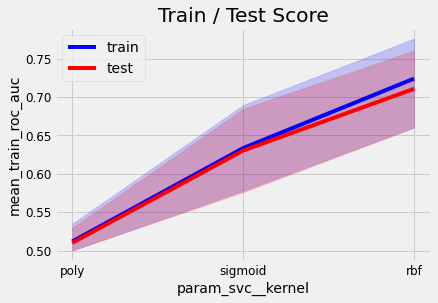

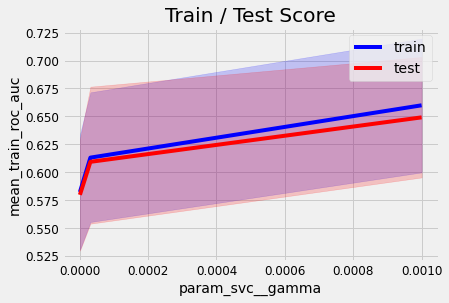

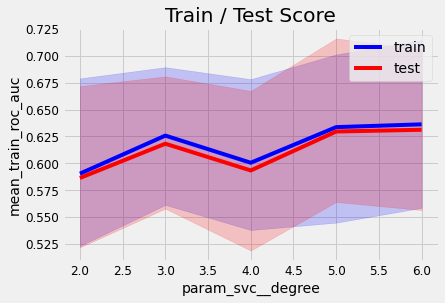

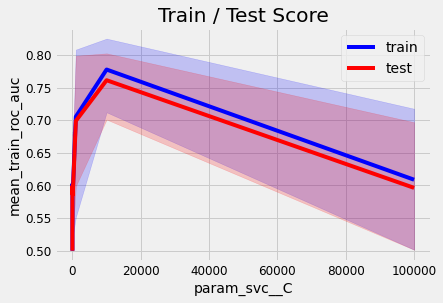

In [33]:
svm_tuning  = pd.DataFrame(svm_cv.cv_results_)
params = list(svm_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=svm_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=svm_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'])
    plt.title('Train / Test Score')
    plt.show()

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       224
           1       0.39      0.83      0.53        35

    accuracy                           0.80       259
   macro avg       0.68      0.81      0.70       259
weighted avg       0.89      0.80      0.83       259



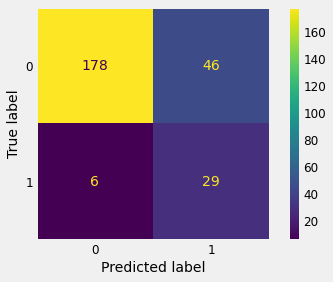

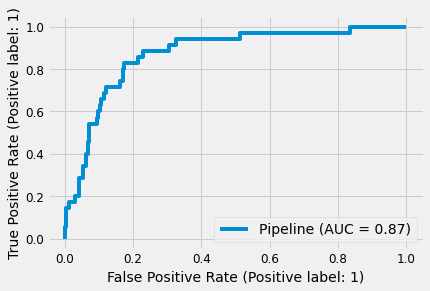

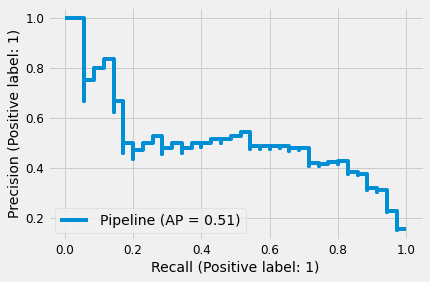

In [34]:
clf = svm_cv.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plot_roc_curve(clf, X_val, y_val)
plot_precision_recall_curve(clf, X_val, y_val)

In [35]:
best_svm_model = svm_cv.best_estimator_
dump(best_svm_model, './red_wines_svm.joblib') 

['./red_wines_svm.joblib']

Saving figure Svc decision boundary


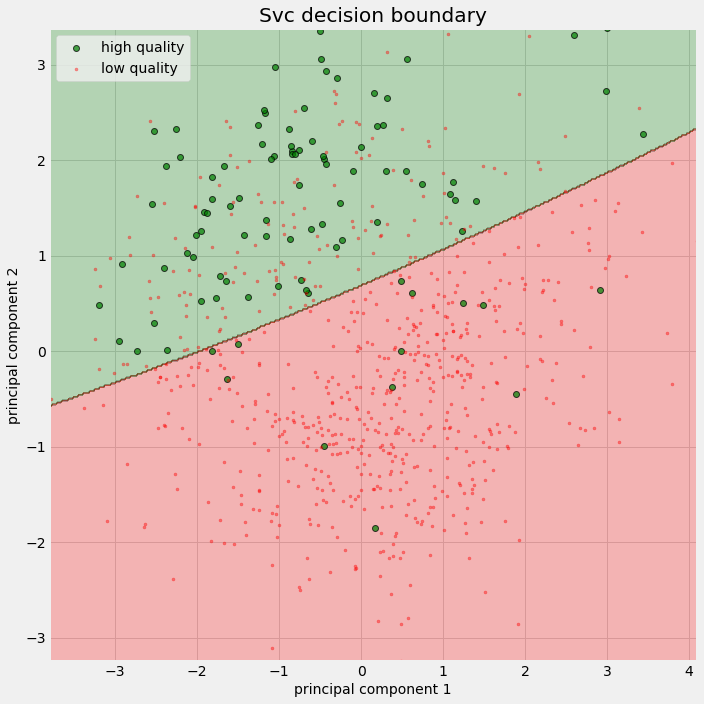

In [36]:
plot_decision_boundary_pca(reds, best_svm_model)

In [37]:
#plot_dark_decision_boundary(reds, best_svm_model)

# Ensemble Model

In [38]:
gb_min_samples_leafs = rf_min_samples_leafs
gb_min_samples_splits = rf_min_samples_splits
gb_n_estimators= np.linspace(5000, 15000, 10).astype(int)
gb_min_samples_split = np.linspace(0.1, 0.7, 10)
gb_learning_rate =  np.logspace(-3, -2, 10)
gb_min_samples_splits = np.linspace(0.1, 0.4, 10)

In [39]:
gb_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
logr_pipeline = make_pipeline(PowerTransformer(), LogisticRegression(random_state=0, class_weight='balanced'))
sgd_pipeline = make_pipeline(PowerTransformer(), SGDClassifier(class_weight='balanced'))
cart_pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight='balanced'))
rbf_pipeline = make_pipeline(PowerTransformer(), SVC(class_weight='balanced', random_state=0, probability=True))
neighbors_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [40]:
final_estimators = {'gb':gb_pipeline, 
                    'sgd':sgd_pipeline,
                    'knn': neighbors_pipeline,
                    'logr':logr_pipeline, 
                    'cart':cart_pipeline,
                    'rbf':rbf_pipeline}

Saving figure Gradientboostingclassifier decision boundary


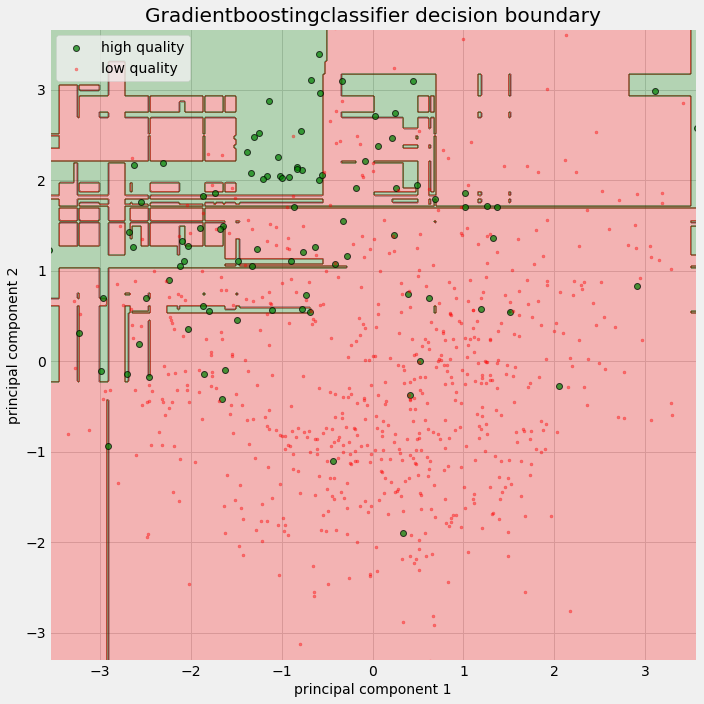

Saving figure Sgdclassifier decision boundary


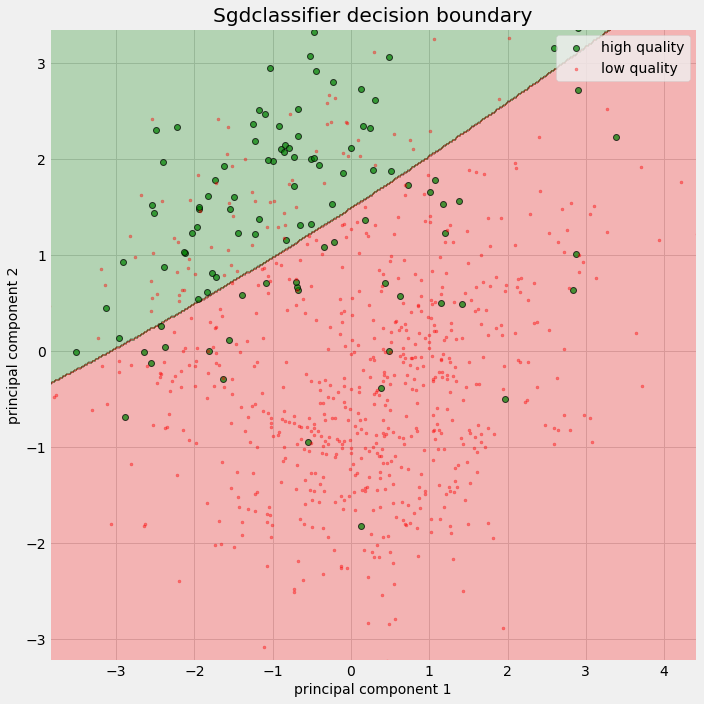

Saving figure Kneighborsclassifier decision boundary


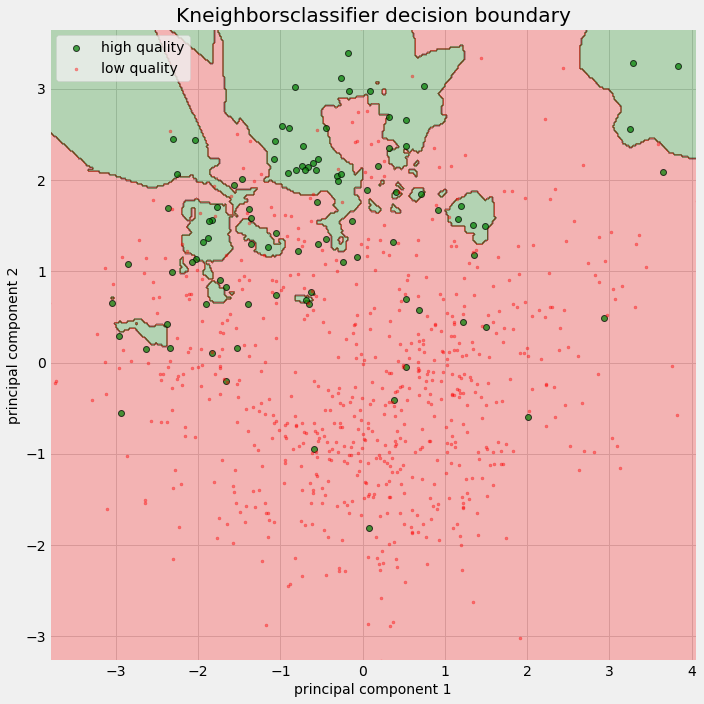

Saving figure Logisticregression decision boundary


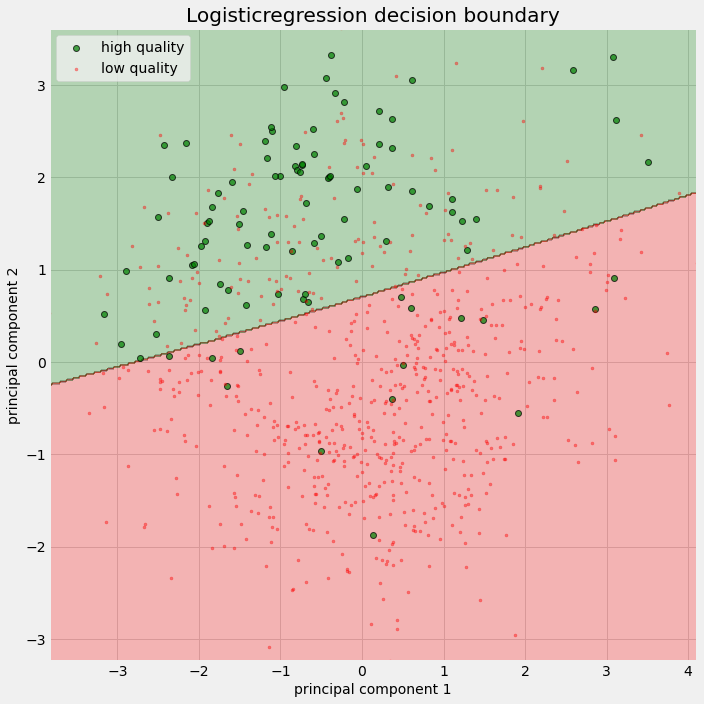

Saving figure Decisiontreeclassifier decision boundary


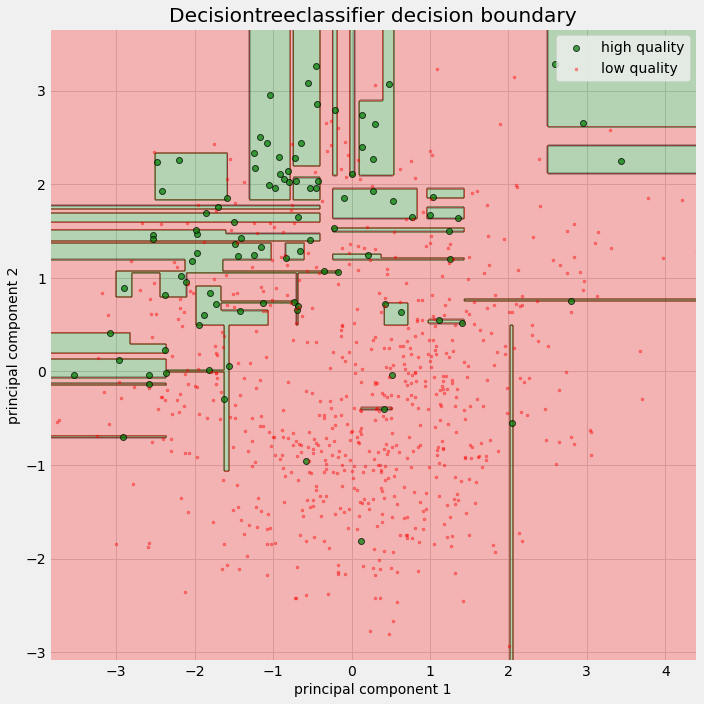

Saving figure Svc decision boundary


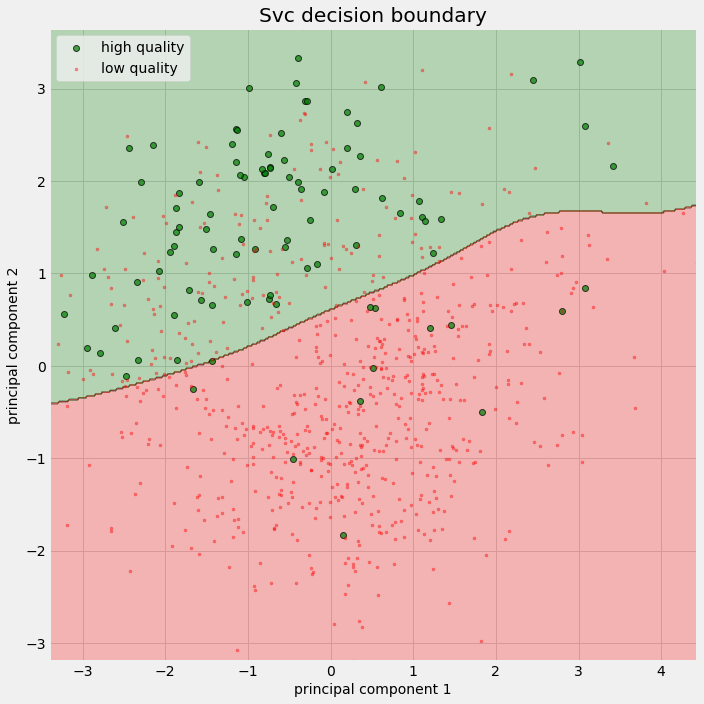

In [41]:
for key, estimator in final_estimators.items():
    plot_decision_boundary_pca(reds, estimator)

In [42]:
%%time
estimators = [
    ("RandomForest", rf_cv.best_estimator_),
    ("Logistsic", lgr_cv.best_estimator_),
    ("SVM", svm_cv.best_estimator_),
    ('KNN', knn_cv.best_estimator_)
]

stacking_classifier = StackingClassifier(estimators=estimators, passthrough=True, n_jobs=-1, final_estimator=None)



params = {
 'final_estimator' : [None, gb_pipeline, sgd_pipeline, logr_pipeline, cart_pipeline, neighbors_pipeline, rbf_pipeline]
}

search = GridSearchCV(stacking_classifier,
                            param_grid=params,
                            cv=5,
                            scoring=scoring, 
                            refit='roc_auc',
                            return_train_score=True, 
                            verbose=0)
search.fit(X_train, y_train)

CPU times: user 7.96 s, sys: 607 ms, total: 8.57 s
Wall time: 1min 3s


GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('RandomForest',
                                                       Pipeline(steps=[('standardscaler',
                                                                        StandardScaler()),
                                                                       ('randomforestclassifier',
                                                                        RandomForestClassifier(class_weight='balanced',
                                                                                               criterion='entropy',
                                                                                               max_depth=26.0,
                                                                                               min_samples_leaf=0.18818181818181817,
                                                                                               min_samples_split=0.37,
                                                                                               n_estimators=57,
                                                                                               n_jobs=-1,
                                                                                               random_state=0))])),
                                                      ('Logists...
                                             Pipeline(steps=[('powertransformer',
                                                              PowerTransformer()),
                                                             ('svc',
                                                              SVC(class_weight='balanced',
                                                                  probability=True,
                                                                  random_state=0))])]},
             refit='roc_auc', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'geo_mean': make_scorer(g_mean_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [43]:
search.best_estimator_

StackingClassifier(estimators=[('RandomForest',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        criterion='entropy',
                                                                        max_depth=26.0,
                                                                        min_samples_leaf=0.18818181818181817,
                                                                        min_samples_split=0.37,
                                                                        n_estimators=57,
                                                                        n_jobs=-1,
                                                                        random_state=0))])),
                               ('Logistsic',
                                Pipeline(steps=[('powert...
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(algorithm='brute',
                                                                      leaf_size=60,
                                                                      n_jobs=-1,
                                                                      n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('powertransformer',
                                                    PowerTransformer()),
                                                   ('logisticregression',
                                                    LogisticRegression(class_weight='balanced',
                                                                       random_state=0))]),
                   n_jobs=-1, passthrough=True)

In [44]:
results = pd.DataFrame(search.cv_results_)
results[['param_final_estimator', 'mean_train_roc_auc','mean_test_roc_auc']].sort_values(by='mean_test_roc_auc', ascending=False)

,param_final_estimator,mean_train_roc_auc,mean_test_roc_auc
3,"(PowerTransformer(), LogisticRegression(class_...",0.776259,0.792284
6,"(PowerTransformer(), SVC(class_weight='balance...",0.824932,0.764096
2,"(PowerTransformer(), SGDClassifier(class_weigh...",0.739946,0.734467
4,"(StandardScaler(), DecisionTreeClassifier(clas...",0.613291,0.638572
5,"(StandardScaler(), KNeighborsClassifier())",0.716698,0.630476
1,"(StandardScaler(), ([DecisionTreeRegressor(cri...",0.660396,0.622303
0,None,0.641528,0.604628


In [45]:
final_est = results.sort_values(by='mean_test_roc_auc', ascending=False)['param_final_estimator'].iloc[1]
final_est

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('svc',
                 SVC(class_weight='balanced', probability=True,
                     random_state=0))])

In [46]:
%%time
estimators = [
    ("RandomForest", rf_cv.best_estimator_),
    ("Logistsic", lgr_cv.best_estimator_),
    ("SVM", svm_cv.best_estimator_),
     ('KNN', knn_cv.best_estimator_)
]

stacking_classifier = StackingClassifier(estimators=estimators, passthrough=True, n_jobs=-1, final_estimator=final_est)



params = {
   'final_estimator__svc__C':svm_penalties,
 'final_estimator__svc__gamma': svm_gammas,
 'final_estimator__svc__kernel': ['sigmoid', 'rbf', 'poly'],
 'final_estimator__svc__degree':[2,3,4,5,6]
}
search = RandomizedSearchCV(stacking_classifier,
                            params,
                            cv=5,
                            n_iter=10,
                            scoring=scoring, 
                            refit='roc_auc',
                            return_train_score=True, 
                            verbose=0)
search.fit(X_train, y_train)


CPU times: user 12.9 s, sys: 838 ms, total: 13.7 s
Wall time: 1min 21s


RandomizedSearchCV(cv=5,
                   estimator=StackingClassifier(estimators=[('RandomForest',
                                                             Pipeline(steps=[('standardscaler',
                                                                              StandardScaler()),
                                                                             ('randomforestclassifier',
                                                                              RandomForestClassifier(class_weight='balanced',
                                                                                                     criterion='entropy',
                                                                                                     max_depth=26.0,
                                                                                                     min_samples_leaf=0.18818181818181817,
                                                                                                     min_samples_split=0.37,
                                                                                                     n_estimators=57,
                                                                                                     n_jobs=-1,
                                                                                                     random_state=0))])),
                                                            ('L...
                                        'final_estimator__svc__gamma': array([1.00000000e-06, 3.16227766e-05, 1.00000000e-03]),
                                        'final_estimator__svc__kernel': ['sigmoid',
                                                                         'rbf',
                                                                         'poly']},
                   refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

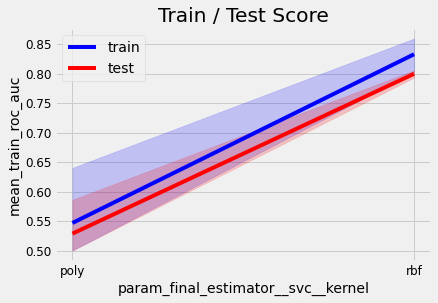

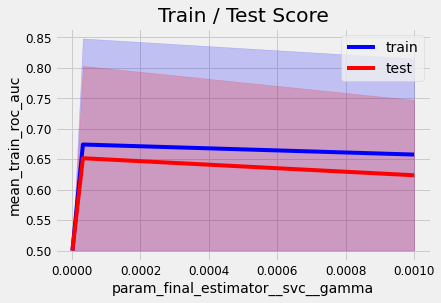

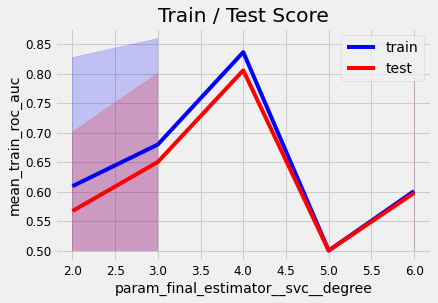

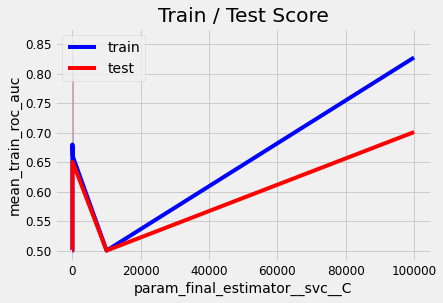

In [47]:
stacking_tuning  = pd.DataFrame(search.cv_results_)
params = list(stacking_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=stacking_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=stacking_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'])
    plt.title('Train / Test Score')
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       224
           1       0.36      0.89      0.51        35

    accuracy                           0.77       259
   macro avg       0.67      0.82      0.68       259
weighted avg       0.89      0.77      0.81       259



['./red_wines_stacking_svm.joblib']

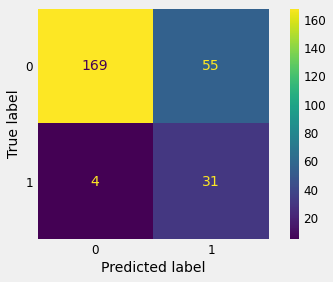

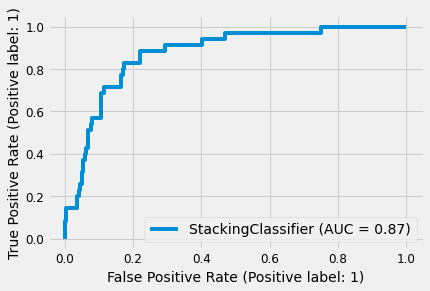

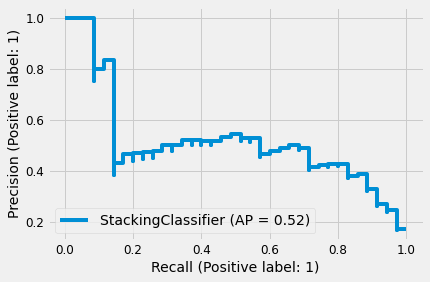

In [48]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plot_roc_curve(clf, X_val, y_val)
plot_precision_recall_curve(clf, X_val, y_val)

from joblib import dump, load
dump(clf, './red_wines_stacking_svm.joblib') 

# Good Recall but Not Great Precision, Check Against Test Data

In [49]:
stacking_svm = search.best_estimator_
cv = cross_validate(stacking_svm, X_train, y_train, cv=5, scoring='roc_auc')

In [50]:
cv['test_score'].mean()

0.8790410875888817

In [51]:
stacking_svm.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForest',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        criterion='entropy',
                                                                        max_depth=26.0,
                                                                        min_samples_leaf=0.18818181818181817,
                                                                        min_samples_split=0.37,
                                                                        n_estimators=57,
                                                                        n_jobs=-1,
                                                                        random_state=0))])),
                               ('Logistsic',
                                Pipeline(steps=[('powert...
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(algorithm='brute',
                                                                      leaf_size=60,
                                                                      n_jobs=-1,
                                                                      n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('powertransformer',
                                                    PowerTransformer()),
                                                   ('svc',
                                                    SVC(C=100.0,
                                                        class_weight='balanced',
                                                        degree=4,
                                                        gamma=3.1622776601683795e-05,
                                                        probability=True,
                                                        random_state=0))]),
                   n_jobs=-1, passthrough=True)

Saving figure stacking_classifier_svc


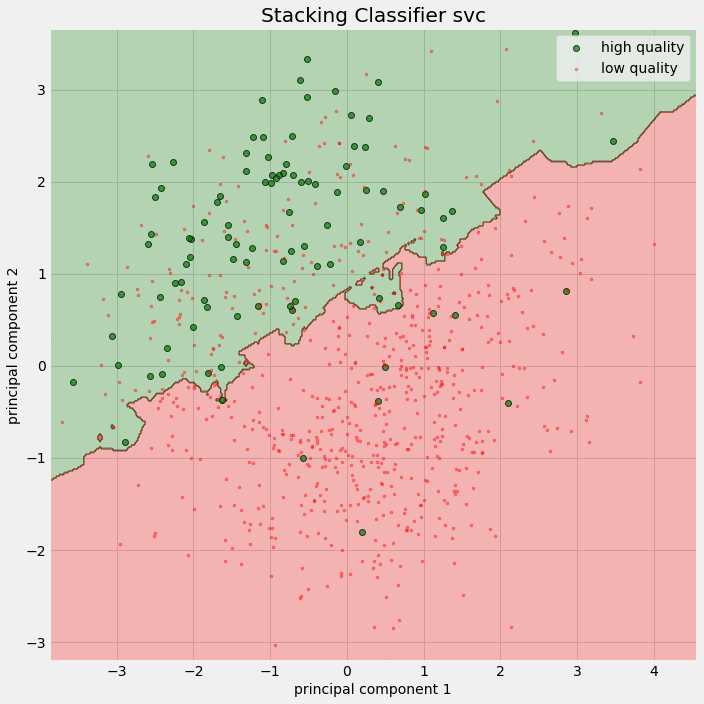

In [52]:
plot_decision_boundary_pca(reds, stacking_svm)

In [53]:
#plot_dark_decision_boundary(reds, stacking_svm)

In [54]:
stacking_svm.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForest',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        criterion='entropy',
                                                                        max_depth=26.0,
                                                                        min_samples_leaf=0.18818181818181817,
                                                                        min_samples_split=0.37,
                                                                        n_estimators=57,
                                                                        n_jobs=-1,
                                                                        random_state=0))])),
                               ('Logistsic',
                                Pipeline(steps=[('powert...
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(algorithm='brute',
                                                                      leaf_size=60,
                                                                      n_jobs=-1,
                                                                      n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('powertransformer',
                                                    PowerTransformer()),
                                                   ('svc',
                                                    SVC(C=100.0,
                                                        class_weight='balanced',
                                                        degree=4,
                                                        gamma=3.1622776601683795e-05,
                                                        probability=True,
                                                        random_state=0))]),
                   n_jobs=-1, passthrough=True)

In [55]:
test = pd.read_pickle('./data/red_test.pkl')
X_test, y_test = test[features], test['quality'].apply(lambda x:0 if x <= 6 else 1)

Saving figure reds_stacking_svc_test_rocauc


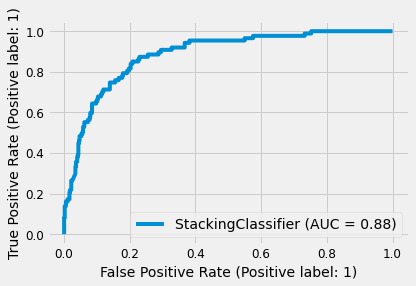

In [56]:
plot_roc_curve(stacking_svm, X_test, y_test)
save_fig('reds_stacking_svc_test_rocauc', resolution=72)

Saving figure reds_stacking_svc_test_conf


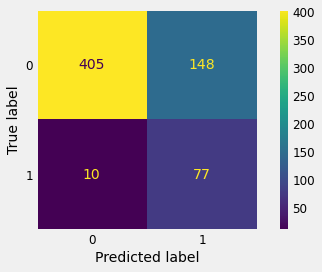

In [57]:
plot_confusion_matrix(stacking_svm, X_test, y_test)
save_fig('reds_stacking_svc_test_conf', resolution=72)
plt.grid(False)

In [58]:
y_pred =stacking_svm.predict(X_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       553
           1       0.34      0.89      0.49        87

    accuracy                           0.75       640
   macro avg       0.66      0.81      0.67       640
weighted avg       0.89      0.75      0.79       640



This is pretty close to what the validation test predicted. Let's see how the other classifiers do on the test data in comparison.

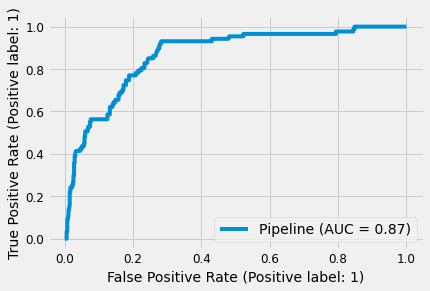

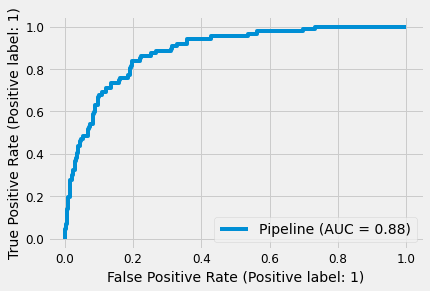

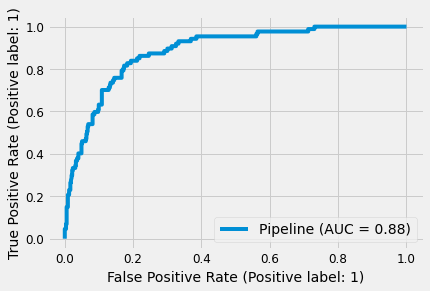

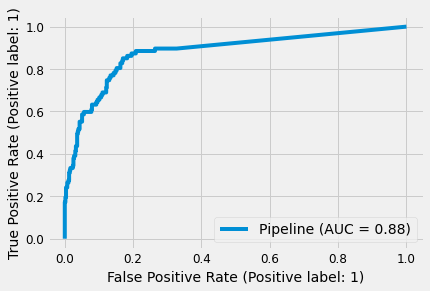

In [60]:
rf_model = rf_cv.best_estimator_.fit(X_train, y_train)
lgr_model = lgr_cv.best_estimator_.fit(X_train, y_train)
svm_model = svm_cv.best_estimator_.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_.fit(X_train, y_train)
plot_roc_curve(rf_model, X_test, y_test)
plot_roc_curve(lgr_model, X_test, y_test)
plot_roc_curve(svm_model, X_test, y_test)
plot_roc_curve(knn_model, X_test, y_test)

# Results

In [61]:
y_pred_proba_1 = stacking_svm.predict_proba(X_test)[:,1]

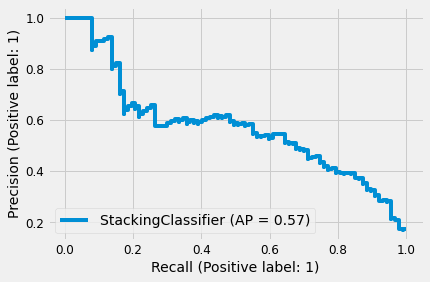

In [62]:
plot_precision_recall_curve(stacking_svm, X_test, y_test)

Text(0.5, 1.0, 'Precisions Recalls vs. Thresholds')

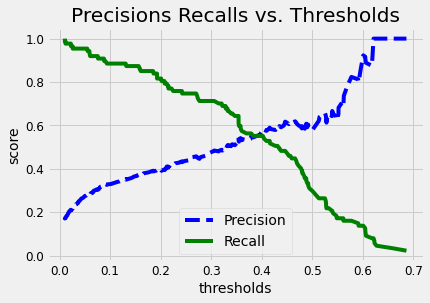

In [63]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_1)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.legend()
plt.xlabel('thresholds')
plt.ylabel('score')
plt.title("Precisions Recalls vs. Thresholds")

<AxesSubplot:xlabel='1', ylabel='0'>

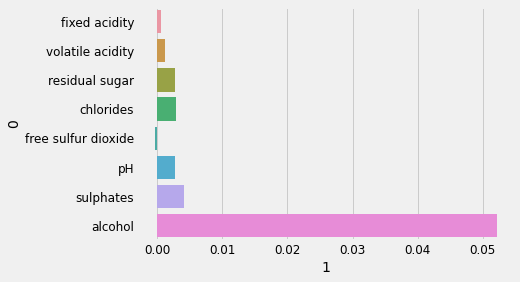

In [64]:
from sklearn.inspection import permutation_importance
r = permutation_importance(stacking_svm, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
feature_importances = pd.DataFrame(list(zip(X_test.columns, r.importances_mean)))
sns.barplot(data=feature_importances, x=1, y=0)

# GB model

In [65]:
results[['param_final_estimator', 'mean_train_precision','mean_test_precision']].sort_values(by='mean_test_precision', ascending=False).iloc[0]

param_final_estimator        None
mean_train_precision     0.679006
mean_test_precision      0.553939
Name: 0, dtype: object

In [66]:
%%time
estimators = [
    ("RandomForest", rf_cv.best_estimator_),
    ("Logistsic", lgr_cv.best_estimator_),
    ("SVM", svm_cv.best_estimator_),
    ('KNN', knn_cv.best_estimator_)
]

stacking_classifier = StackingClassifier(estimators=estimators, passthrough=True, n_jobs=-1, final_estimator=gb_pipeline)



params = {
 'final_estimator__gradientboostingclassifier__n_estimators': gb_n_estimators,
   'final_estimator__gradientboostingclassifier__learning_rate': gb_learning_rate,
    'final_estimator__gradientboostingclassifier__min_samples_split':gb_min_samples_splits,
    'final_estimator__gradientboostingclassifier__min_samples_leaf': gb_min_samples_leafs,
    'final_estimator__gradientboostingclassifier__max_depth': [3,5,10, 50, 100,200, 300],
    'final_estimator__gradientboostingclassifier__loss':['deviance', 'exponential'],
    'final_estimator__gradientboostingclassifier__max_features':['log2', 'sqrt', 'auto', None],
    'final_estimator__gradientboostingclassifier__subsample':[0.1, 0.3, 0.5, 0.7, 1.0]
    
}

search = RandomizedSearchCV(stacking_classifier,
                            params,
                            cv=5,
                            n_iter=10,
                            scoring=scoring, 
                            refit='roc_auc',
                            return_train_score=True, 
                            verbose=0)
search.fit(X_train, y_train)


CPU times: user 6min 10s, sys: 6.36 s, total: 6min 17s
Wall time: 8min 29s


RandomizedSearchCV(cv=5,
                   estimator=StackingClassifier(estimators=[('RandomForest',
                                                             Pipeline(steps=[('standardscaler',
                                                                              StandardScaler()),
                                                                             ('randomforestclassifier',
                                                                              RandomForestClassifier(class_weight='balanced',
                                                                                                     criterion='entropy',
                                                                                                     max_depth=26.0,
                                                                                                     min_samples_leaf=0.18818181818181817,
                                                                                                     min_samples_split=0.37,
                                                                                                     n_estimators=57,
                                                                                                     n_jobs=-1,
                                                                                                     random_state=0))])),
                                                            ('L...
                                        'final_estimator__gradientboostingclassifier__n_estimators': array([ 5000,  6111,  7222,  8333,  9444, 10555, 11666, 12777, 13888,
       15000]),
                                        'final_estimator__gradientboostingclassifier__subsample': [0.1,
                                                                                                   0.3,
                                                                                                   0.5,
                                                                                                   0.7,
                                                                                                   1.0]},
                   refit='roc_auc', return_train_score=True,
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'geo_mean': make_scorer(g_mean_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

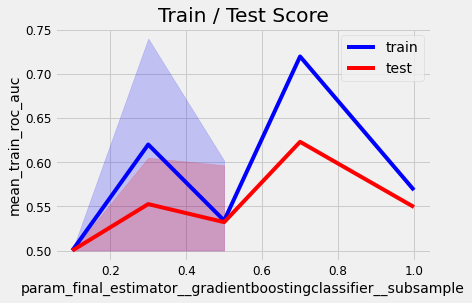

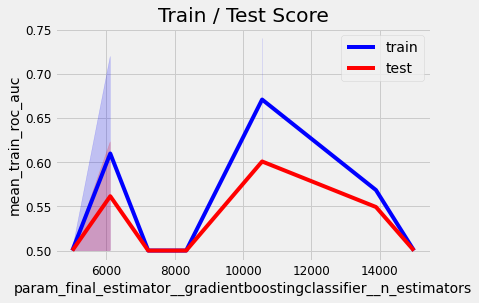

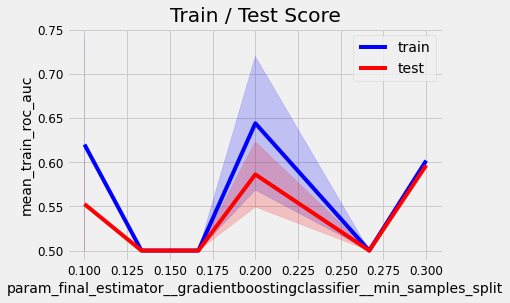

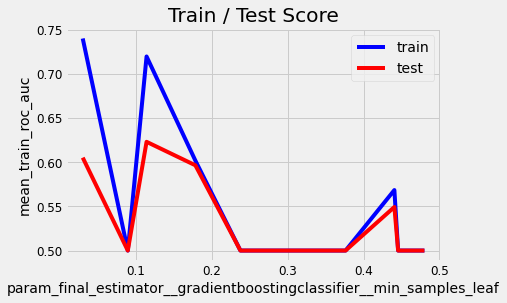

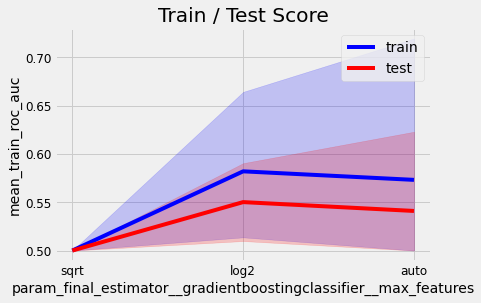

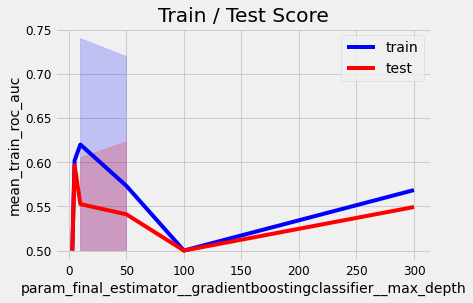

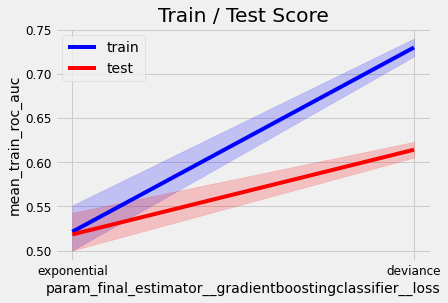

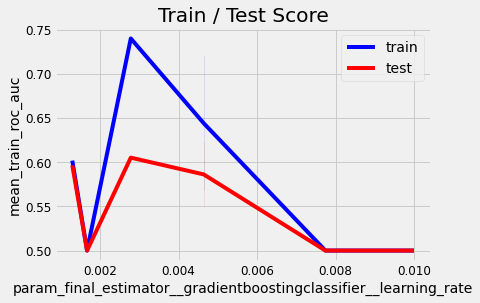

In [67]:
stacking_tuning  = pd.DataFrame(search.cv_results_)
params = list(stacking_tuning['params'][0].keys())
params = ["param_" + param for param in params]
for param in params:
    sns.lineplot(data=stacking_tuning,
                 x = param,
                 y='mean_train_roc_auc',
                 color='b')
    sns.lineplot(data=stacking_tuning,
                 x = param,
                 y='mean_test_roc_auc',
                 color='r')
    plt.legend(['train', 'test'])
    plt.title('Train / Test Score')
    plt.show()

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       224
           1       0.47      0.26      0.33        35

    accuracy                           0.86       259
   macro avg       0.68      0.61      0.63       259
weighted avg       0.84      0.86      0.84       259



['./red_wines_stacking_gb.joblib']

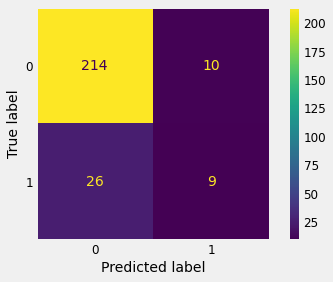

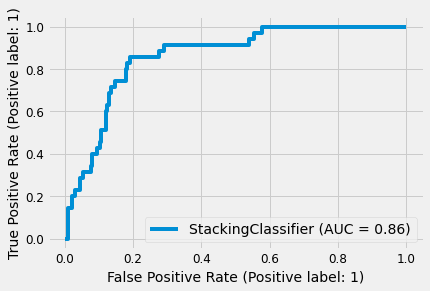

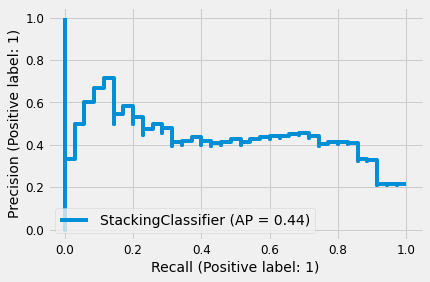

In [68]:
clf = search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(clf, X_val, y_val)
plt.grid(False)
plot_roc_curve(clf, X_val, y_val)
plot_precision_recall_curve(clf, X_val, y_val)

from joblib import dump, load
dump(clf, './red_wines_stacking_gb.joblib') 

In [69]:
stacking_gb = search.best_estimator_
cv = cross_validate(stacking_gb, X_train, y_train, cv=5, scoring='roc_auc')

In [70]:
cv['test_score'].mean()

0.8646320162680456

In [71]:
stacking_gb.fit(X_train, y_train)
y_pred = stacking_gb.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       224
           1       0.47      0.26      0.33        35

    accuracy                           0.86       259
   macro avg       0.68      0.61      0.63       259
weighted avg       0.84      0.86      0.84       259



In [72]:
#plot_dark_decision_boundary(reds, stacking_gb)

Saving figure stacking_classifier_gradientboostingclassifier


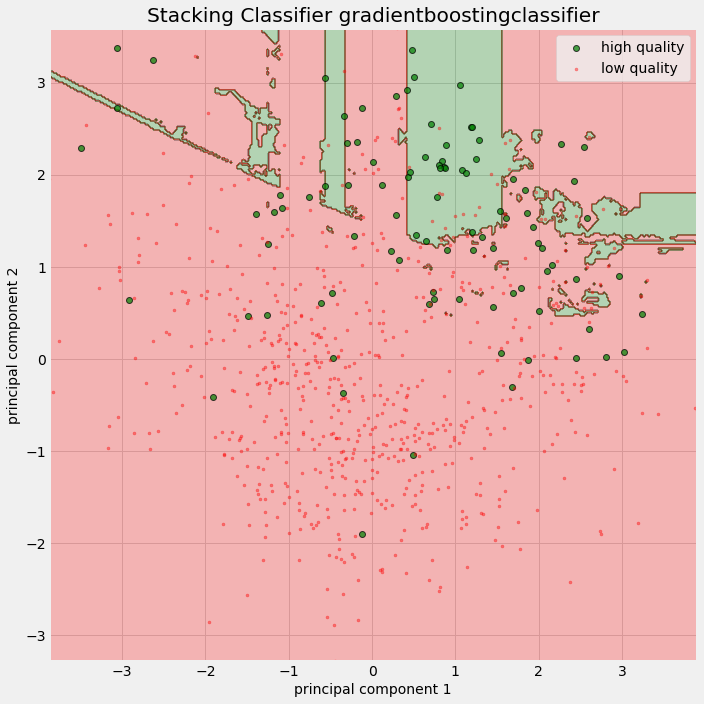

In [73]:
plot_decision_boundary_pca(reds, stacking_gb)

In [74]:
stacking_gb.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForest',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        criterion='entropy',
                                                                        max_depth=26.0,
                                                                        min_samples_leaf=0.18818181818181817,
                                                                        min_samples_split=0.37,
                                                                        n_estimators=57,
                                                                        n_jobs=-1,
                                                                        random_state=0))])),
                               ('Logistsic',
                                Pipeline(steps=[('powert...
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('gradientboostingclassifier',
                                                    GradientBoostingClassifier(learning_rate=0.004641588833612777,
                                                                               max_depth=50,
                                                                               max_features='auto',
                                                                               min_samples_leaf=0.11393939393939392,
                                                                               min_samples_split=0.2,
                                                                               n_estimators=6111,
                                                                               random_state=0,
                                                                               subsample=0.7))]),
                   n_jobs=-1, passthrough=True)

In [75]:
test = pd.read_pickle('./data/red_test.pkl')
X_test, y_test = test[features], test['quality'].apply(lambda x:0 if x <= 6 else 1)

Saving figure stacking_clf_gb_confm


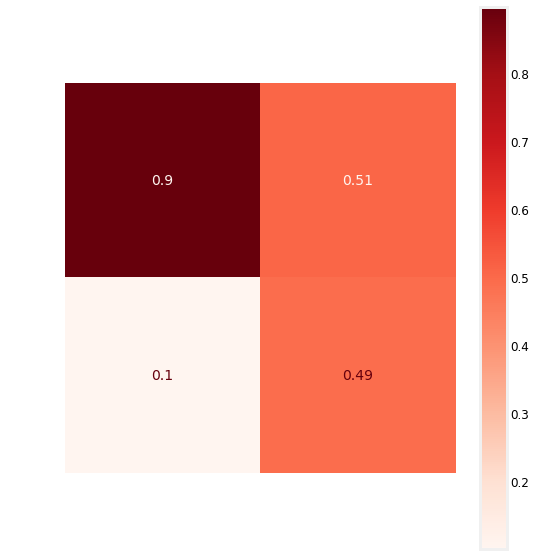

In [76]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
f.patch.set_facecolor('red')
f.patch.set_alpha(0.0)

# Predictions to obtain the classification results



# Plotting

plot_confusion_matrix(stacking_gb, X_test, y_test, cmap='Reds', normalize='pred', ax=ax1)
plt.xticks(ticks=[0,1], labels=['low', 'high'], color='white', size=16)
plt.yticks(ticks=[0,1], labels=['low', 'high'], color='white', size=16)
plt.grid(False)

ax1.spines['top'].set_color(None)
ax1.spines['bottom'].set_color(None)
ax1.spines['left'].set_color(None)
ax1.spines['right'].set_color(None)
ax1.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.set_xlabel("Predicted",size = 14, c='white')
ax1.set_ylabel("True",size = 16, c='white')
ax1.patch.set_facecolor('white')
ax1.patch.set_alpha(0.0)
ax1.grid(False)


ax1.set_title('red Wines Test Data', c='white')
plt.savefig('./slides/figures/plots/red_confusion_matrix', bbox_inches='tight',facecolor=f.get_facecolor(), edgecolor='none')
save_fig('stacking_clf_gb_confm', resolution=72)

plt.show()

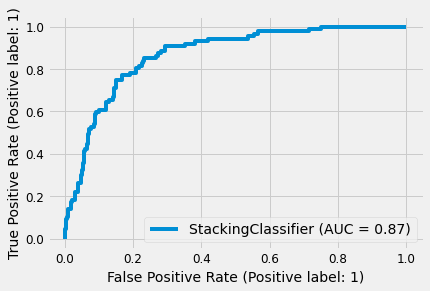

In [77]:
plot_roc_curve(stacking_gb, X_test, y_test)

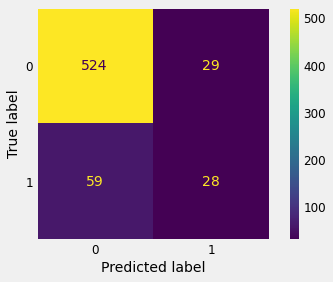

In [78]:
plot_confusion_matrix(stacking_gb, X_test, y_test)
plt.grid(False)

In [79]:
y_pred = stacking_gb.predict(X_test)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       553
           1       0.49      0.32      0.39        87

    accuracy                           0.86       640
   macro avg       0.70      0.63      0.66       640
weighted avg       0.84      0.86      0.85       640



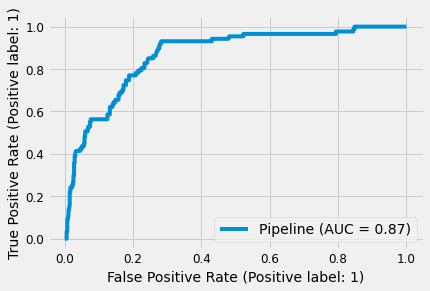

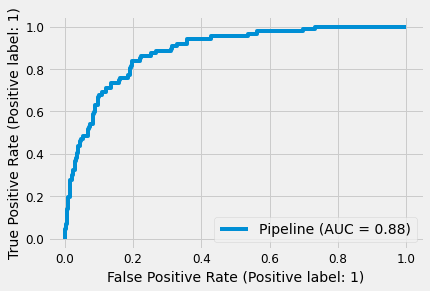

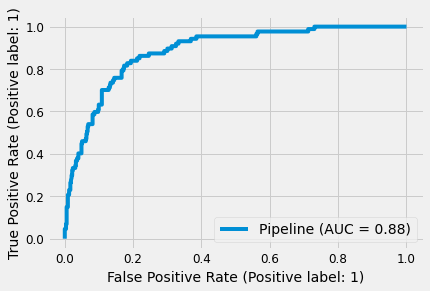

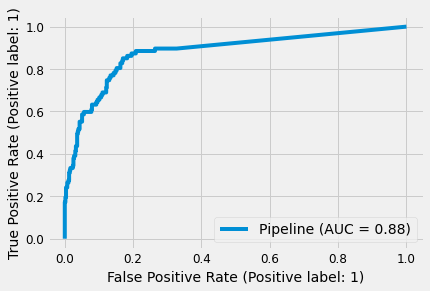

In [81]:
rf_model = rf_cv.best_estimator_.fit(X_train, y_train)
lgr_model = lgr_cv.best_estimator_.fit(X_train, y_train)
svm_model = svm_cv.best_estimator_.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_.fit(X_train, y_train)
plot_roc_curve(rf_model, X_test, y_test)
plot_roc_curve(lgr_model, X_test, y_test)
plot_roc_curve(svm_model, X_test, y_test)
plot_roc_curve(knn_model, X_test, y_test)

# Results

In [82]:
y_pred_proba_1 = stacking_gb.predict_proba(X_test)[:,1]

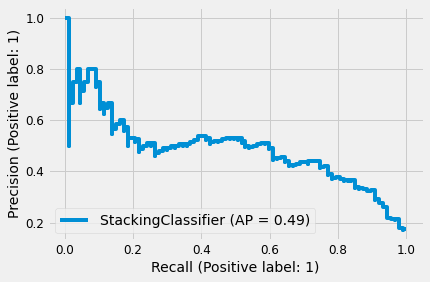

In [83]:
plot_precision_recall_curve(stacking_gb, X_test, y_test)

Saving figure all_classifiers


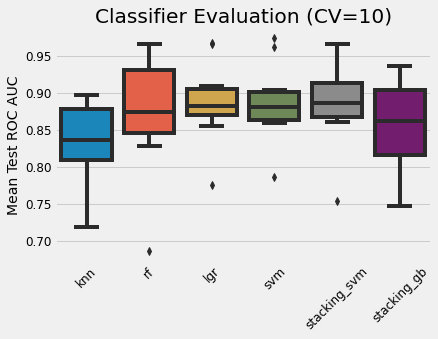

<Figure size 720x720 with 0 Axes>

In [98]:
models = {'knn':knn_model, 'rf':rf_model, 'lgr':lgr_model, 'svm':svm_model, 'stacking_svm':stacking_svm, 'stacking_gb':stacking_gb}
metrics = pd.DataFrame()
all_models = pd.DataFrame()
for key, model in models.items():
    result = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc')
    metric = pd.DataFrame(result)
    metric['model'] = key
    metrics = metrics.append(metric)
    all_models[key] = pd.DataFrame(result)['test_score']
sns.boxplot(data = all_models)
plt.ylabel('Mean Test ROC AUC')
plt.xticks(rotation=45)
plt.title('Classifier Evaluation (CV=10)')
plt.figure(figsize=(10,10))
save_fig('all_classifiers', resolution=72)
plt.show()
    

In [99]:
metrics.to_csv('./reds_metrics_file', sep='\t')

In [86]:
all_models['cross_val_run'] = all_models.index
all_models = all_models.set_index('cross_val_run')
all_models.to_csv('./reds_metrics_file', sep='\t')

In [87]:
all_models

,knn,rf,lgr,svm,stacking_svm,stacking_gb
cross_val_run,,,,,,
0,0.821429,0.838170,0.854911,0.859375,0.875000,0.816964
1,0.804688,0.939732,0.966518,0.973214,0.946429,0.915179
2,0.857143,0.944196,0.908482,0.904018,0.915179,0.924107
3,0.829293,0.901010,0.872727,0.862626,0.866667,0.864646
4,0.894949,0.872727,0.876768,0.892929,0.896970,0.870707
5,0.896970,0.965657,0.965657,0.961616,0.965657,0.935354
6,0.884848,0.874747,0.892929,0.874747,0.905051,0.858586
7,0.842424,0.869697,0.868687,0.866667,0.870707,0.785859
8,0.749495,0.828283,0.886869,0.886869,0.860606,0.816162


Text(0.5, 1.0, 'Precisions Recalls vs. Thresholds')

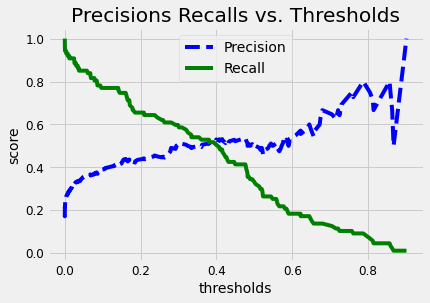

In [88]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_1)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.legend()
plt.xlabel('thresholds')
plt.ylabel('score')
plt.title("Precisions Recalls vs. Thresholds")

Saving figure stacking_classifier_gb_feat_imp


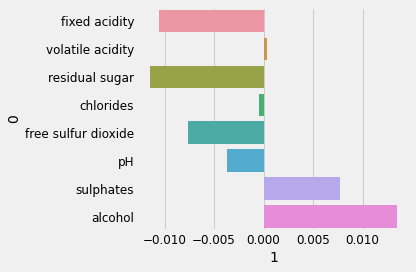

In [89]:
from sklearn.inspection import permutation_importance
r = permutation_importance(stacking_gb, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
feature_importances = pd.DataFrame(list(zip(X_test.columns, r.importances_mean)))
sns.barplot(data=feature_importances, x=1, y=0)
save_fig('stacking_classifier_gb_feat_imp', resolution=72)